{/* cspell:ignore CMAES, Hypoelastic, edgecolor, royalblue, rstride, cstride */}

# QUICK-PDE: A Qiskit Function by ColibriTD

<Admonition type="note">
  Qiskit Functions are an experimental feature available to IBM Quantum&reg; Premium Plan and Flex Plan users. They are in preview release status and subject to change.
</Admonition>

## Overview

The Partial Differential Equation (PDE) solver presented here is part of our Quantum Innovative Computing Kit (QUICK) platform (QUICK-PDE), and is packaged as a Qiskit Function. With the QUICK-PDE function, you can solve domain-specific partial differential equations on IBM Quantum QPUs. This function is based on the algorithm described in [ColibriTD's H-DES description paper.](https://arxiv.org/abs/2410.01130) This algorithm can solve complex multi-physics problems, starting with Computational Fluid Dynamics (CFD) and Materials Deformation (MD), and other use cases coming soon.

To tackle the differential equations, the trial solutions are encoded as linear combinations of orthogonal functions (typically Chebyshev polynomials, and more specifically $2^n$ of them where $n$ is the number of qubits encoding your function), parametrized by the angles of a Variable Quantum Circuit (VQC). The ansatz generates a state encoding the function, which is evaluated by observables whose combinations allow for evaluating the function at all points. You can then evaluate the loss function in which the differential equations are encoded, and fine-tune the angles in a hybrid loop, as shown in the following. The trial solutions get gradually closer to the actual solutions until you reach a satisfactory result.

![Workflow of the QUICK-PDE function](/docs/images/guides/colibritd-equation-solver/diagram.svg)

In addition to this hybrid loop, you can also chain together different optimizers. This is useful when you want a global optimizer to find a good set of angles, and then a more fine-tuned optimizer to follow a gradient to the best set of neighboring angles. In the case of computational fluid dynamics (CFD), the default optimization sequence produces the best results - but in the case of material deformation (MD), while the default provides good results, you can configure it further for problem-specific benefits.

Note for each variable of the function, we specify number of qubits (which you can play with). By stacking 10 identical circuits and evaluating the 10 identical observables on different qubits throughout one big circuit, you can noise-mitigate within the CMA optimization process, relying on the noise learner method, and significantly reduce the number of shots needed.

## Input/output

### Computational Fluid Dynamics

The inviscid Burgers' equation, models flowing non-viscous fluids as follows:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = 0,$$

$u$ represents the fluid speed field. This use-case has a temporal boundary condition: you can select the initial condition and then allow the system to relax. Currently, the only accepted initial conditions are linear functions: $ax + b$.

The arguments for CFD's differential equations are on a fixed grid, as follows:

> $t$ is between 0 and 0.95 with 30 sample points. $x$ is between 0 and 0.95 with a step size of 0.2375.

### Material Deformation

This use case focuses on hypoelastic deformation with the one-dimensional tensile test, in which a bar fixed in space is pulled at its other extremity. We describe the problem as follows:

$$u' - \frac{\sigma}{3K} - \frac{2}{\sqrt{3}}\epsilon_0\left(\frac{\sigma'}{\sigma_0\sqrt{3}}\right)^n = 0$$

$$\sigma' - b = 0,$$

$K$ represents the bulk modulus of the material being stretched, $n$ the exponent of a power law, $b$ the force per unit mass, $\epsilon_0$ the proportional stress limit, $\sigma_0$ the proportional strain limit, $u$ the stress function, and $\sigma$ the strain function.

The considered bar is of unitary length. This use-case has a boundary condition for surface stress $t$, or the amount of work needed to stretch the bar.

The arguments for MD's differential equations are on a fixed grid, as follows:

> $x$ is between 0 and 1 with a step size of 0.04.

### Input

In order to run the QUICK-PDE Qiskit Function, you can adjust the following parameters:

| Name              | Type                                                 | Description                                                                                                                                                                                                                                                                     | Use-case specific | Example                  |
| ----------------- | ---------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------- | ------------------------ |
| use_case          | `Literal["MD", "CFD"]`                               | Toggle to select the system of differential equations to solve                                                                                                                                                                                                                  | No                | `"CFD"`                  |
| parameters        | `dict[str, Any]`                                     | Parameters of the differential equation (see the next table for more detail)                                                                                                                                                                                              | No                | `{"a": 1.0, "b": 1.0}`   |
| nb_qubits         | `Optional[dict[str, dict[str, int]]]`                | Number of qubits per function and per variable. Optimized values are chosen by the function, but if you want to try to find a better combination, you can override the default values                                                                         | No                | `{"u": {"x": 1, "t":3}}` |
| depth             | `Optional[dict[str, int]]`                           | Depth of ansatz per function. Optimized values are chosen by the function, but if you want to try to find a better combination, you can override the default values                                                                                           | No                | `{"u": 4}`               |
| optimizer         | `Optional[list[str]]`                                | Optimizers to be used, either "CMAES" from the [`cma` python library](https://github.com/CMA-ES/pycma) or one of the [optimizers of scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)                                                   | MD                | `"SLSQP"`                |
| shots             | `Optional[list[int]]`                                | Number of shots used to run each circuit. Since several optimization steps are needed, the length of the list must be equal to the number of optimizers used (4 in the case of CFD). Defaults to `[50_000] * nb_optimizers` for MD and `[5_00, 2_000, 5_000, 10_000]` for CFD | No                | `[15_000, 30_000]`       |
| optimizer_options | `Optional[dict[str, Any]]`                           | Options to pass to the optimizer. The details of this input depends on the optimizer used; for specifics, refer to the documentation of the optimizer used                                                                                              | MD                | `{"maxiter": 50 }`       |
| initialization    | `Optional[Literal["RANDOM", "PHYSICALLY_INFORMED"]]` | Whether to start with random angles or smartly chosen angles. Beware that smartly chosen angles may not work in 100% of the cases. Defaults to `"PHYSICALLY_INFORMED"`.                                                                                                         | No                | `"RANDOM"`               |
| backend_name      | `Optional[str]`                                      | The backend name to use.                                                                                                                                                                                                              | No                | `"ibm_torino"`           |
| mode              | `Optional[Literal["job", "session", "batch"]]`        | The execution mode to use. Defaults to `"job"`.                                                                                                                                                                                                                                       | No                | `"job"`                  |

The parameters of the differential equation (physical parameters and boundary condition) should follow the given format:

| Use case | Key         | Value type | Description                              | Example |
| -------- | ----------- | ---------- | ---------------------------------------- | ------- |
| CFD      | `a`         | `float`    | Coefficient of the initial values of $u$ | `1.0`   |
| CFD      | `b`         | `float`    | Offset of the initial values of $u$      | `1.0`   |
| MD       | `t`         | `float`    | surface stress                           | `12.0`  |
| MD       | `K`         | `float`    | bulk modulus                             | `100.0` |
| MD       | `n`         | `int`      | power law                                | `4.0`   |
| MD       | `b`         | `float`    | force per unit mass                      | `10.0`  |
| MD       | `epsilon_0` | `float`    | proportional stress limit                | `0.1`   |
| MD       | `sigma_0`   | `float`    | proportional strain limit                | `5.0`   |

### Output

The output is a dictionary with the list of sample points, as well as the values of the functions at each of these points:

In [ ]:
from numpy import array

In [ ]:
solution = {
    "functions": {
        "u": array(
            [
                [0.01, 0.1, 1],
                [0.02, 0.2, 2],
                [0.03, 0.3, 3],
                [0.04, 0.4, 4],
            ]
        ),
    },
    "samples": {
        "t": array([0.1, 0.2, 0.3, 0.4]),
        "x": array([0.5, 0.6, 0.7]),
    },
}

The shape of a solution array depends on the variables' samples:

In [ ]:
assert len(solution["functions"]["u"].shape) == len(solution["samples"])
for col_size, samples in zip(
    solution["functions"]["u"].shape, solution["samples"].values()
):
    assert col_size == len(samples)

The mapping between the function variables' sample points and the solution array's dimension is done in alphanumeric order of the variable's name. For example, if the variables are `"t"` and `"x"`, a row of `solution["functions"]["u"]` represents the values of the solution for a fixed `"t"`, and a column of `solution["functions"]["u"]` represents the values of the solution for a fixed `"x"`.

The following is an example of how to get the value of the function for a specific set of coordinate:

In [ ]:
# u(t=0.2, x=0.7) == 2
assert solution["samples"]["t"][1] == 0.2
assert solution["samples"]["x"][2] == 0.7
assert solution["functions"]["u"][1, 2] == 2

## Benchmarks

The following table presents statistics on various runs of our function.

| Example                      | Number of qubits | Initialization        | Error     | Total time (min) | Runtime usage (min) |
| ---------------------------- | ---------------- | --------------------- | --------- | ---------------- | ------------------- |
| Inviscid Burgers' equation   | 50               | `PHYSICALLY_INFORMED` | $10^{-2}$ | 66               | 25                  |
| Hypoelastic 1D tensile test  | 18               | `RANDOM`              | $10^{-2}$ | 123              | 100                 |

## Get started

Fill out the [form to request access to the QUICK-PDE function.](https://forms.office.com/e/kJzViZNVa4) Then, authenticate using your [API key](http://quantum.cloud.ibm.com/) and select the function as follows:

In [ ]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

catalog = QiskitFunctionsCatalog(
    channel="ibm_cloud / ibm_quantum / ibm_quantum_platform",
    instance="USER_CRN / HGP",
    token="USER_API_KEY / IQP_API_TOKEN",
)

quick = catalog.load("colibritd/quick-pde")

## Examples

To get started, try one of the following examples:

### Computational Fluid Dynamics (CFD)

When initial conditions are set to $u(0,x) = x$, the results are as follows:

In [ ]:
# launch the simulation with initial conditions u(0,x) = a*x + b
job = quick.run(use_case="cfd", physical_parameters={"a": 1.0, "b": 0.0})

Check your Qiskit Function workload's [status](/docs/guides/functions#check-job-status) or return [results](/docs/guides/functions#retrieve-results) as follows:

In [ ]:
print(job.status())
solution = job.result()

'QUEUED'

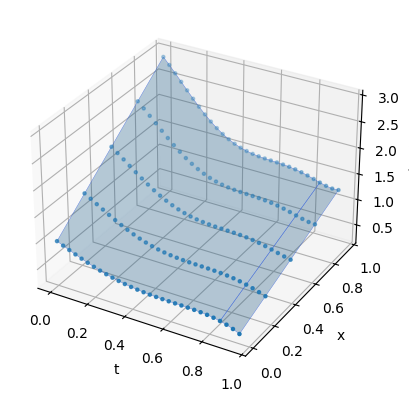

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

_ = plt.figure()
ax = plt.axes(projection="3d")

# plot the solution using the 3d plotting capabilities of pyplot
t, x = np.meshgrid(solution["samples"]["t"], solution["samples"]["x"])
ax.plot_surface(
    t,
    x,
    solution["functions"]["u"],
    edgecolor="royalblue",
    lw=0.25,
    rstride=26,
    cstride=26,
    alpha=0.3,
)
ax.scatter(t, x, solution["functions"]["u"], marker=".")
ax.set(xlabel="t", ylabel="x", zlabel="u(t,x)")

plt.show()

### Material Deformation

The material deformation use case requires the physical parameters of your material and the applied force, as follows:

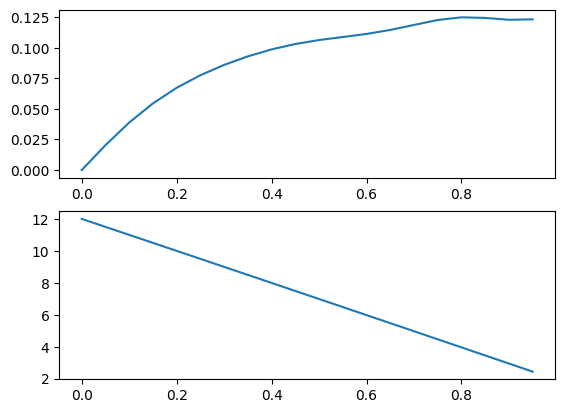

In [ ]:
import matplotlib.pyplot as plt

# select the properties of your material
job = quick.run(
    use_case="md",
    physical_parameters={
        "t": 12.0,
        "K": 100.0,
        "n": 4.0,
        "b": 10.0,
        "epsilon_0": 0.1,
        "sigma_0": 5.0,
    },
)

# plot the result
solution = job.result()

_ = plt.figure()
stress_plot = plt.subplot(211)
plt.plot(solution["samples"]["x"], solution["functions"]["u"])
strain_plot = plt.subplot(212)
plt.plot(solution["samples"]["x"], solution["functions"]["sigma"])

plt.show()

## Fetch error messages

If your workload status is `ERROR`, use `job.error_massage()` to fetch the error message to help debug, as follows:

In [ ]:
job = quick.run(use_case="mdf", physical_params={})

print(job.error_message())

# or write a wrapper around it for a more human readable version
def pprint_error(job):
    print("".join(eval(job.error_message())["error"]))

print("___")
pprint_error(job)

{"error": ["qiskit.exceptions.QiskitError: 'Unknown argument \"physical_params\", did you make a typo? -- https://docs.quantum.ibm.com/errors#1804'\n"]}
___
qiskit.exceptions.QiskitError: 'Unknown argument "physical_params", did you make a typo? -- https://docs.quantum.ibm.com/errors#1804'



## Get support

For support, contact qiskit-function-support@colibtitd.com.

## Next steps

<Admonition type="tip" title="Recommendations">
- Fill out the form to [request access to the QUICK-PDE function.](https://forms.office.com/e/kJzViZNVa4)
- Try modeling a flowing non-viscous fluid using QUICK-PDE in the [tutorial](/docs/tutorials/colibritd-pde).
</Admonition>